# Code Modularization
- Author: Marcellinus Aditya Witarsah
- Date: 22 July 2024

**Model training:**
1. Data Preprocessing: Split data, and transform into a Weight of Evidence.
2. Train: Modelling: Using Logistic Regression.
3. Evaluation: Evaluate on model on train and test data.

**Model inference:**
1. Credit score scaling: using the information from the Logistic Regression coefficients to generate score points.

In [1]:
# Imports
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Data Manipulation

import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Scorecard Modelling:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Extras:
import pickle
from scipy import stats
from typing import Tuple
from typing import Union

pd.set_option('display.max_colwidth', None)

# Data Load

In [ ]:
# Load and inspect data
df = pd.read_csv("../data/raw/credit_risk_dataset.csv")
display(df.head())
display(df.info())
display(df.describe())

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


None

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


# Data Preparation
1. Data Splitting: Split the data into training and testing datasets.
2. Weight of Evidence (WOE) and Information Value (IV) Calculation: Calculate the WoE and IV for each predictor variable.
3. WoE Transformation: Transform the dataset values into WoE values using the calculated WoE mappings.

## Data Splitting

In [ ]:
# Prepare arguments
df = pd.read_csv('../data/raw/credit_risk_dataset.csv')
target_variable = 'loan_status'
test_size = 0.3
random_state = 42

# Split data betweem train and text
X, y = df.drop(columns=[target_variable]), df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, shuffle=True, random_state=random_state)

print(f'Train features: {X_train.shape}, Train Target: {y_train.shape}')
print(f'Test features: {X_test.shape}, Test Target: {y_test.shape}')

Train features: (22806, 11), Train Target: (22806,)
Test features: (9775, 11), Test Target: (9775,)


## Data Preprocessing and Modelling
**Weight of Evidence (WOE) and Logistic Regression**
- Create a Weight of Evidence transformer inherited from the scikit learn objects: BaseEstimator, and TransformerMixin.
- Create a class that combine Weight of Evidence transformer and Logistic Regression model using Pipeline class.


In [ ]:
import numpy as np
import pandas as pd
from typing import Union
from sklearn.base import BaseEstimator, TransformerMixin


class WOETransformer(BaseEstimator, TransformerMixin):
    def __init__(self, numerical_columns: list, categorical_columns: list, bins: int):
        """
        Initialize `WOETransformer` class.

        Args:
            numerical_columns (list): list of numerical column names.
            categorical_columns (list): categorical column names from the dataset.
            bins (int): number of bins.
        """
        self.numerical_columns = numerical_columns
        self.categorical_columns = categorical_columns
        self.bins = bins
        self.woe_dict = {}
        self.woe_df = pd.DataFrame()
        self.iv_df = pd.DataFrame()

    def __generate_bins(
        self, df: pd.DataFrame, numerical_columns: list, bins: int
    ) -> pd.DataFrame:
        """
        Create bins for a numerical column, dividing it into a specified number of equal-sized bins.

        Args:
            df (pd.DataFrame): Pandas DataFrame containing the data.
            numerical_columns (str): list of numerical column names.
            bins (int): number of bins.
        Returns:
            pd.DataFrame: Pandas DataFrame with `numerical_column` values are changed to bin.
        """
        for numerical_column in numerical_columns:
            df[numerical_column] = pd.qcut(
                df[numerical_column], q=bins, duplicates="drop"
            )
        return df

    def __fill_missing_categorical(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Fill missing categorical columns inside Pandas DataFrame with `Missing`. All data must already been binned.

        Args:
            df (pd.DataFrame): Pandas DataFrame containing the data.
        Returns:
            pd.DataFrame: Pandas DataFrame with `numerical_column` values are changed to bin.
        """
        for column in df.columns:
            if df[column].isna().sum() > 0 and df[column].dtype in [
                "object",
                "category",
            ]:
                # Add category 'Missing' to replace the missing values
                df[column] = df[column].cat.add_categories("Missing")
                # Replace missing values with category 'Missing'
                df[column] = df[column].fillna(value="Missing")
        return df

    def __get_woe(self, value: Union[int, float], column_name: str) -> float:
        """
        Tranform column values into weight of evidence value.

        Args:
            value (Union[int, float]): value of the column.
            column_name (str): column name to be mapped to WOE value.

        Returns:
            float: weight of evidence value.
        """
        woe_value = None
        if isinstance(value, int) or isinstance(value, float):
            for interval, woe in self.woe_dict[column_name].items():
                if isinstance(interval, pd.Interval) and value in interval:
                    woe_value = woe
        if isinstance(value, str):
            woe_value = self.woe_dict[column_name][value]
        return woe_value

    def __interpret_information_value(self, value: float) -> str:
        """
        Interpret the strength of the information value.

        Args:
            value (float): information value.

        Returns:
            str: interpretation of the information value.
        """
        if value < 0.02:
            return "Not Predictive"
        elif 0.02 <= value and value < 0.1:
            return "Weak Predictive"
        elif 0.1 <= value and value < 0.3:
            return "Medium Predictive"
        elif 0.3 <= value and value < 0.5:
            return "Strong Predictive"
        else:
            return "Very Strong Predictive"

    def fit(
        self, X: pd.DataFrame, y: pd.Series = None
    ) -> Union[BaseEstimator, TransformerMixin]:
        """
        Perform binning, weight of evidence and information value calculation.

        Args:
            X (pd.DataFrame): Pandas DataFrame containing the data (predictor).
            y (pd.Series, optional): Pandas Series containing labels. Defaults to None.

        Returns:
            Union[BaseEstimator, TransformerMixin]: WOETransformer object
        """

        # 1. Perform binning on numerical column
        X_binned = self.__generate_bins(
            X.copy(deep=False), self.numerical_columns, self.bins
        )
        X_binned = self.__fill_missing_categorical(X_binned)

        # 2. Count the occurrences of the target inside each bin of the columns.
        crosstabs = {}
        for column in X_binned.columns:
            crosstabs[column] = pd.crosstab(X_binned[column], y, margins=True)

        # 3. Calculate weight of evidence for all columns
        for column, crosstab in crosstabs.items():
            # 3.1 Calculate WOE
            crosstab["proportion_not_default"] = crosstab[0] / crosstab[0]["All"]
            crosstab["proportion_default"] = crosstab[1] / crosstab[1]["All"]
            crosstab["WOE"] = np.log(
                crosstab["proportion_not_default"] / crosstab["proportion_default"]
            )
            temp_df = crosstab.reset_index().iloc[:-1, [0, -1]].copy()
            temp_df.columns = ["Value", "WOE"]

            self.woe_dict[column] = {
                row["Value"]: row["WOE"] for _, row in temp_df.iterrows()
            }  # for woe values mapping

            temp_df.loc[:, "Characteristic"] = column
            self.woe_df = pd.concat(
                (self.woe_df, temp_df), axis=0
            )  # for pandas DataFrame

            # 3.2 Calculate information value
            IV = np.sum(
                (crosstab["proportion_not_default"] - crosstab["proportion_default"])
                * crosstab["WOE"]
            )
            self.iv_df = pd.concat(
                (
                    self.iv_df,
                    pd.DataFrame(
                        {"Characteristic": [column], "Information Value": [IV]}
                    ),
                ),
                axis=0,
            )
            self.iv_df["Interpretation"] = self.iv_df["Information Value"].apply(
                lambda x: self.__interpret_information_value(x)
            )
            self.iv_df = self.iv_df.sort_values(by="Information Value", ascending=False)
        return self

    def transform(self, X: pd.DataFrame, y: pd.Series = None) -> pd.DataFrame:
        """
        Mapping predictor values into its weight of evidence values.

        Args:
            X (pd.DataFrame): Pandas DataFrame containing the data (predictor).
            y (pd.Series, optional): Pandas Series containing labels. Defaults to None.

        Returns:
            pd.DataFrame: Transformed predictor variable in form of weight of evidence values.
        """
        X_transformed = X.copy(deep=False)
        for column in X.columns:
            X_transformed[column] = X_transformed[column].apply(
                lambda x: self.__get_woe(x, column)
            )
            X_transformed[column] = X_transformed[column].fillna(
                self.woe_dict.get("Missing", 0)
            )
        return X_transformed

# Modelling
Use Logistic Regression due to its simplicity, interpretability, and transparency in prediction.

In [ ]:
import time
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Union
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from credit_score_modelling.metrics import roc_auc, pr_auc, gini, ks
from credit_score_modelling.config import logger


class WOELogisticRegression(BaseEstimator, TransformerMixin):
    def __init__(self, pipeline: Pipeline):
        """
        Initialize the WOELogisticRegression with a given pipeline.

        Args:
            pipeline (Pipeline): The scikit-learn pipeline containing the WOE transformer and Logistic Regression.
        """
        self.pipeline = pipeline

    @classmethod
    def from_file(cls, file_path: Union[str, Path]):
        """
        Create an instance of WOELogisticRegression from a saved pipeline file.

        Args:
            file_path (Union[str, Path]): Path to the file containing the saved pipeline.

        Returns:
            WOELogisticRegression: An instance of WOELogisticRegression initialized with the loaded pipeline.
        """
        with open(file_path, "rb") as file:
            pipeline = pickle.load(file)
        logger.info(
            "Load {} model from {} file".format(pipeline.__class__.__name__, file_path)
        )
        return cls(pipeline)

    @classmethod
    def from_parameters(cls, woe_transformer_params: dict, logreg_params: dict):
        """
        Create an instance of WOELogisticRegression from parameters for WOE transformer and Logistic Regression.

        Args:
            woe_transformer_params (dict): Parameters for the WOE transformer.
            logreg_params (dict): Parameters for the Logistic Regression.

        Returns:
            WOELogisticRegression: An instance of WOELogisticRegression initialized with the created pipeline.
        """
        pipeline = Pipeline(
            [
                (
                    WOETransformer.__name__,
                    WOETransformer(**woe_transformer_params),
                ),
                (LogisticRegression.__name__, LogisticRegression(**logreg_params)),
            ]
        )
        logger.info("{} model created".format(pipeline.__class__.__name__))
        return cls(pipeline)

    def fit(
        self, X: pd.DataFrame, y: pd.Series = None
    ) -> Union[BaseEstimator, TransformerMixin]:
        """
        Fit the pipeline to the training data.

        Args:
            X (pd.DataFrame): Training feature data.
            y (pd.Series, optional): Training target data. Defaults to None.

        Returns:
            Union[BaseEstimator, TransformerMixin]: The fitted WOELogisticRegression instance.
        """
        start_time = time.perf_counter()
        self.pipeline.fit(X, y)
        elapsed_time = time.perf_counter() - start_time
        logger.info(
            "{} model training finished in {:.2f} seconds.".format(
                self.pipeline.__class__.__name__, elapsed_time
            )
        )
        return self

    def predict(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Make predictions using the fitted pipeline.

        Args:
            X (pd.DataFrame): Feature data for making predictions.

        Returns:
            pd.DataFrame: Predictions made by the pipeline.
        """
        start_time = time.perf_counter()
        y_pred = self.pipeline.predict(X)
        elapsed_time = time.perf_counter() - start_time
        logger.info(
            "{} model prediction finished in {:.2f} seconds.".format(
                self.pipeline.__class__.__name__, elapsed_time
            )
        )
        return y_pred

    def predict_proba(self, X: pd.DataFrame) -> np.ndarray:
        """
        Predict probabilities using the fitted pipeline.

        Args:
            X (pd.DataFrame): Feature data for making probability predictions.

        Returns:
            np.ndarray: Predicted probabilities.
        """
        start_time = time.perf_counter()
        y_pred_proba = self.pipeline.predict_proba(X)
        elapsed_time = time.perf_counter() - start_time
        logger.info(
            "{} model prediction probability finished in {:.2f} seconds.".format(
                self.pipeline.__class__.__name__, elapsed_time
            )
        )
        return y_pred_proba

    def evaluate(
        self, X_test: pd.DataFrame, y_true: pd.Series, type: str = "Training"
    ) -> tuple:
        """
        Evaluate the pipeline on test data.

        Args:
            X_test (pd.DataFrame): Test feature data.
            y_true (pd.Series): True labels for the test data.
            type (str, optional): Type of evaluation ("Training" or "Validation"). Defaults to "Training".

        Returns:
            tuple: A tuple containing ROC AUC, PR AUC, GINI, and KS scores.
        """
        start_time = time.perf_counter()
        y_pred_proba = self.predict_proba(X_test)[:, 1]
        roc_auc_score = roc_auc(y_true, y_pred_proba)
        pr_auc_score = pr_auc(y_true, y_pred_proba)
        gini_score = gini(y_true, y_pred_proba)
        ks_score = ks(y_true, y_pred_proba)
        logger.info(
            "{} Performance >>> ROC AUC: {:.2f}, PR AUC: {:.2f}, GINI: {:.2f}, KS SCORE: {:.2f}".format(
                type,
                roc_auc_score,
                pr_auc_score,
                gini_score,
                ks_score,
            )
        )
        elapsed_time = time.perf_counter() - start_time
        logger.info(
            "{} model evaluation finished in {:.2f} seconds.".format(
                self.pipeline.__class__.__name__, elapsed_time
            )
        )
        return (roc_auc_score, pr_auc_score, gini_score, ks_score)

    def save(self, file: Path) -> None:
        """
        Save the pipeline to a file.

        Args:
            file (Path): Path to the file where the pipeline should be saved.
        """
        start_time = time.perf_counter()
        with open(file, "wb") as file:
            pickle.dump(self.pipeline, file)
        elapsed_time = time.perf_counter() - start_time
        logger.info(
            "Save {} model finished in {:.2f} seconds.".format(
                self.pipeline.__class__.__name__, elapsed_time
            )
        )

In [ ]:
# Train Model
woe_transformer_params = {
    'numerical_columns': X_train.select_dtypes("number").columns,
    'categorical_columns': X_train.select_dtypes(["object", "category"] ).columns,
    'bins': 5,
}
logreg_params = {
    'random_state': 42
}
woe_logreg_model = WOELogisticRegression.from_parameters(
    woe_transformer_params = woe_transformer_params,
    logreg_params = logreg_params,
)

woe_logreg_model.fit(X_train, y_train)

2024-07-22 19:17:59.684 | INFO     | __main__:from_parameters:63 - Pipeline model created


2024-07-22 19:18:01.304 | INFO     | __main__:fit:82 - Pipeline model training finished in 1.62 seconds.


WOELogisticRegression(pipeline=Pipeline(steps=[('WOETransformer',
                                                WOETransformer(bins=5,
                                                               categorical_columns=Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object'),
                                                               numerical_columns=Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'],
      dtype='object'))),
                                               ('LogisticRegression',
                                                LogisticRegression(random_state=42))]))

# Evaluation
Evaluation metrics that are chosen are used to assess the ***model's discriminative ability*** rather than conventional classification metrics like recall, precision, and F1-score: While recall, precision, and F1-score are useful in many classification contexts, credit risk models are often evaluated on their ability to rank-order risk and their calibration.
    
Evaluation metrics that are being chosen are:
- ***ROC AUC (Receiver Operating Characteristic Area Under the Curve)***: Measures the model's ability to distinguish between classes. It provides an aggregate measure of performance across all classification thresholds.
- ***Precision-Recall Curve***: Particularly useful in cases of imbalanced classes. It focuses on the performance related to the positive class (default cases).
- ***Gini Coefficient***: A variant of the AUC, often used in credit scoring, which ranges from 0 to 1. It measures the ability of the model to differentiate between good and bad accounts.
- ***Kolmogorov-Smirnov (KS) Statistic***: Evaluates the maximum separation between the cumulative distributions of the good and bad accounts. Higher KS values indicate better model performance.
- ***Model Calibration***: Assesses how well the predicted probabilities of default align with the actual default rates. Good calibration means that the predicted risk levels reflect true risks accurately.

In [ ]:
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import calibration_curve
from credit_score_modelling.config import logger


def plot_calibration_curve(
    y_true: np.array,
    y_pred_proba: np.array,
    model_name: str,
    path: str = None,
    n_bins=10,
) -> plt.figure:
    """
    Plot calibration curve.

    Args:
        y_pred_proba (np.array): Predicted probabilities for the positive class (default).
        y_true (np.array): True binary labels (0 for not default, 1 for default).
        model_name (str): Name of the model for labeling the plot.
        figsize (Tuple[int, int]): Size of the plot.
        path (str): Path to store plot image.
        n_bins (int): Number of bins to use for calibration curve.
    Return:
        plt.Axes: Matplotlib axis object.
    """
    start_time = time.perf_counter()
    prob_true, prob_pred = calibration_curve(y_true, y_pred_proba, n_bins=n_bins)

    plt.style.use("fivethirtyeight")
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], linestyle="--", label="Perfectly calibrated")
    ax.plot(prob_pred, prob_true, marker="o", label=model_name)
    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Fraction of positives")
    ax.set_title("Calibration plot")
    ax.legend()
    ax.grid(True)

    image = fig

    if path is not None:
        # Save figure
        fig.savefig(path, bbox_inches="tight")

    elapsed_time = time.perf_counter() - start_time
    logger.info(
        "Generating calibration curve plot finished in {:.2f} seconds.".format(
            elapsed_time
        )
    )
    return image


def plot_pred_proba_distribution(y_true: np.array, y_pred_proba: np.array, path: str = None) -> plt.Axes:
    """
    Plot the predicted probability distributions for the default and non-default classes.

    Args:
        y_pred_proba (np.array): Predicted probabilities for the positive class (default).
        y_true (np.array): True binary labels (0 for not default, 1 for default).
        figsize (Tuple[int, int]): size of the plot.
    Return:
        plt.Axes: Matplotlib axis object.
    """
    start_time = time.perf_counter()
    plt.style.use("fivethirtyeight")
    fig, ax = plt.subplots()

    sns.histplot(
        y_pred_proba[y_true == 0],
        label="Not Default",
        kde=True,
        alpha=0.6,
        bins=30,
        ax=ax,
    )
    sns.histplot(
        y_pred_proba[y_true == 1],
        label="Default",
        kde=True,
        alpha=0.6,
        bins=30,
        ax=ax,
    )

    ax.set_title(
        "Predicted Probability Distributions for Default and Not Default",
        fontsize=16,
        fontweight="bold",
    )
    ax.set_xlabel("Predicted Probability", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.legend(title="Label", fontsize=12, title_fontsize="13")
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    image = fig

    if path is not None:
        # Save figure
        fig.savefig(path, bbox_inches="tight")
        
        
    elapsed_time = time.perf_counter() - start_time
    logger.info(
        "Generating probability distributions plot finished in {:.2f} seconds.".format(
            elapsed_time
        )
    )
    return image


def plot_roc_curve(y_true: np.array, y_pred_proba: np.array, path: str = None) -> plt.Axes:
    """
    Plot the ROC curve and calculate the AUC.

    Args:
        y_pred_proba (np.array): Predicted probabilities for the positive class (default).
        y_true (np.array): True binary labels (0 for not default, 1 for default).
        figsize (Tuple[int, int]): size of the plot.
    Return:
        plt.Axes: Matplotlib axis object.
    """
    start_time = time.perf_counter()
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.style.use("fivethirtyeight")
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    ax.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")

    ax.set_title(
        "Receiver Operating Characteristic (ROC) Curve", fontsize=16, fontweight="bold"
    )
    ax.set_xlabel("False Positive Rate", fontsize=14)
    ax.set_ylabel("True Positive Rate", fontsize=14)
    ax.legend(loc="lower right", fontsize=12)
    ax.grid(axis="both", linestyle="--", alpha=0.7)

    image = fig

    if path is not None:
        # Save figure
        fig.savefig(path, bbox_inches="tight")

    elapsed_time = time.perf_counter() - start_time
    logger.info(
        "Generating ROC curve plot finished in {:.2f} seconds.".format(
            elapsed_time
        )
    )
    return image


def plot_precision_recall_curve(y_true: np.array, y_pred_proba: np.array, path: str = None) -> plt.Axes:
    """
    Plot the Precision-Recall curve and calculate the Average Precision (AP).

    Args:
        y_pred_proba (np.array): Predicted probabilities for the positive class (default).
        y_true (np.array): True binary labels (0 for not default, 1 for default).
        figsize (Tuple[int, int]): size of the plot.
    Return:
        plt.Axes: Matplotlib axis object.
    """
    start_time = time.perf_counter()
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.style.use("fivethirtyeight")
    fig, ax = plt.subplots()
    ax.plot(recall, precision, lw=2, label=f"PR curve (AP = {pr_auc:.2f})")

    ax.set_title("Precision-Recall Curve", fontsize=16, fontweight="bold")
    ax.set_xlabel("Recall", fontsize=14)
    ax.set_ylabel("Precision", fontsize=14)
    ax.legend(loc="lower left", fontsize=12)
    ax.grid(axis="both", linestyle="--", alpha=0.7)

    image = fig

    if path is not None:
        # Save figure
        fig.savefig(path, bbox_inches="tight")

    elapsed_time = time.perf_counter() - start_time
    logger.info(
        "Generating precision recall curve plot finished in {:.2f} seconds.".format(
            elapsed_time
        )
    )
    return image


def plot_ks(y_true: np.array, y_pred_proba: np.array, path: str = None) -> plt.Axes:
    """
    Plot the Kolmogorov-Smirnov (KS) statistic.

    Args:
        y_pred_proba (np.array): Predicted probabilities for the positive class (default).
        y_true (np.array): True binary labels (0 for not default, 1 for default).
        figsize (Tuple[int, int]): size of the plot.
    Return:
        plt.Axes: Matplotlib axis object.
    """
    start_time = time.perf_counter()
    y_pred_proba_not_default = y_pred_proba[y_true == 0]
    y_pred_proba_default = y_pred_proba[y_true == 1]

    ks_stat, p_value = stats.ks_2samp(y_pred_proba_not_default, y_pred_proba_default)

    plt.style.use("fivethirtyeight")
    fig, ax = plt.subplots()
    ax.hist(
        y_pred_proba_not_default,
        bins=50,
        density=True,
        histtype="step",
        cumulative=True,
        label="Not Default",
        linewidth=2,
    )
    ax.hist(
        y_pred_proba_default,
        bins=50,
        density=True,
        histtype="step",
        cumulative=True,
        label="Default",
        linewidth=2,
    )
    ax.set_title("KS Plot")
    ax.set_xlabel("Value")
    ax.set_ylabel("Cumulative Probability")
    ax.legend(title=f"KS Statistic: {ks_stat:.3f}, P-value: {p_value:.3f}")

    image = fig

    if path is not None:
        # Save figure
        fig.savefig(path, bbox_inches="tight")

    elapsed_time = time.perf_counter() - start_time
    logger.info(
        "Generating ks plot finished in {:.2f} seconds.".format(
            elapsed_time
        )
    )
    return image

2024-07-22 19:18:02.195 | INFO     | __main__:predict_proba:122 - Pipeline model prediction probability finished in 0.80 seconds.
2024-07-22 19:18:02.212 | INFO     | __main__:evaluate:149 - Training Performance >>> ROC AUC: 0.87, PR AUC: 0.71, GINI: 0.74, KS SCORE: 0.62
2024-07-22 19:18:02.212 | INFO     | __main__:evaluate:159 - Pipeline model evaluation finished in 0.82 seconds.
2024-07-22 19:18:02.533 | INFO     | __main__:predict_proba:122 - Pipeline model prediction probability finished in 0.32 seconds.
2024-07-22 19:18:03.073 | INFO     | __main__:evaluate:149 - Training Performance >>> ROC AUC: 0.87, PR AUC: 0.72, GINI: 0.74, KS SCORE: 0.61
2024-07-22 19:18:03.073 | INFO     | __main__:evaluate:159 - Pipeline model evaluation finished in 0.86 seconds.
2024-07-22 19:18:03.921 | INFO     | __main__:predict_proba:122 - Pipeline model prediction probability finished in 0.85 seconds.
2024-07-22 19:18:03.934 | INFO     | __main__:plot_calibration_curve:53 - Generating calibration cur

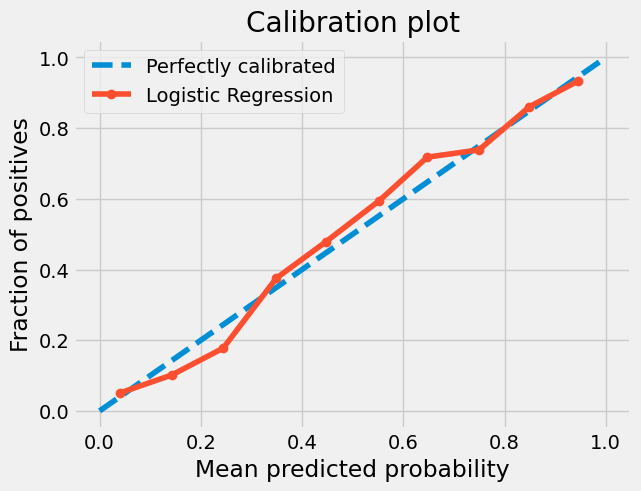

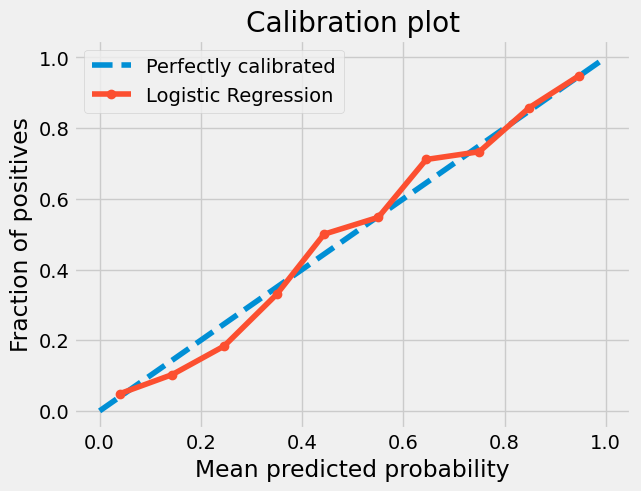

In [ ]:
# Evaluation
woe_logreg_model.evaluate(X_train, y_train)
woe_logreg_model.evaluate(X_test, y_test)

plot_calibration_curve(y_train, woe_logreg_model.predict_proba(X_train)[:, 1], "Logistic Regression")
plot_calibration_curve(y_test, woe_logreg_model.predict_proba(X_test)[:, 1], "Logistic Regression")
plt.show()

2024-07-22 19:18:05.280 | INFO     | __main__:predict_proba:122 - Pipeline model prediction probability finished in 0.75 seconds.
2024-07-22 19:18:05.597 | INFO     | __main__:plot_pred_proba_distribution:111 - Generating probability distributions plot finished in 0.32 seconds.
2024-07-22 19:18:05.697 | INFO     | __main__:plot_roc_curve:154 - Generating ROC curve plot finished in 0.10 seconds.
2024-07-22 19:18:05.714 | INFO     | __main__:plot_precision_recall_curve:194 - Generating precision recall curve plot finished in 0.02 seconds.
2024-07-22 19:18:05.739 | INFO     | __main__:plot_ks:251 - Generating ks plot finished in 0.02 seconds.


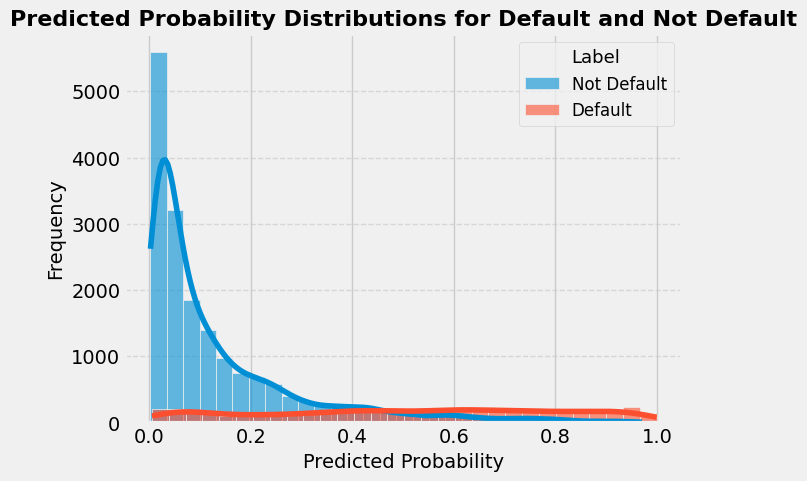

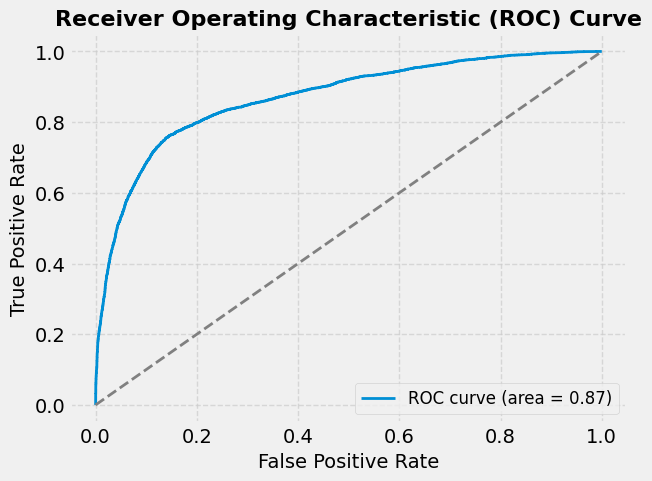

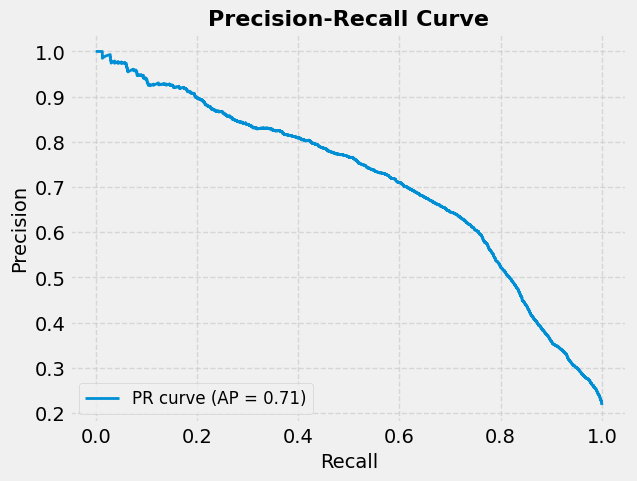

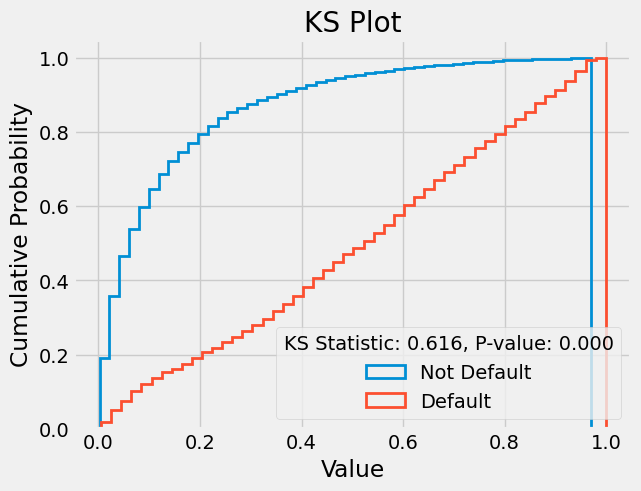

In [ ]:
y_pred_proba = woe_logreg_model.predict_proba(X_train)[:, -1]
plot_pred_proba_distribution(y_train, y_pred_proba)
plot_roc_curve(y_train, y_pred_proba)
plot_precision_recall_curve(y_train, y_pred_proba)
plot_ks(y_train, y_pred_proba)
plt.show()

# Model Inference

In [ ]:
import time
import pandas as pd
import numpy as np
from typing import Union
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from credit_score_modelling.config import logger


class CreditScoreScaling:
    def __init__(
        self,
        pipeline: Pipeline,
        pdo: Union[int, float],
        odds: Union[int, float],
        scorecard_points: Union[int, float],
    ):
        """Initialize the CreditScoreScaling with model pipeline and scorecard parameters.

        Args:
            pipeline (Pipeline): The pipeline containing the trained logistic regression model and WOE transformer.
            pdo (Union[int, float]): Points to Double the Odds.
            odds (Union[int, float]): The odds (Bad/Good) at the scorecard points.
            scorecard_points (Union[int, float]): The scorecard points at the specified odds.
        """
        self.pipeline = pipeline
        self.intercept = self.pipeline[LogisticRegression.__name__].intercept_[0]
        self.n_features = len(
            self.pipeline[LogisticRegression.__name__].feature_names_in_
        )
        self.pdo = pdo
        self.odds = odds
        self.scorecard_points = scorecard_points
        self.factor = self.pdo / np.log(2)
        self.offset = self.scorecard_points - self.factor * np.log(self.odds)
        self.scorecard_map_dict = {}
        self.__generate_scorecard()

    def __generate_mapping(self, scorecard: pd.DataFrame) -> None:
        """
        Generate a mapping of scorecard features and their corresponding points.

        Args:
            scorecard (pd.DataFrame): The scorecard dataframe containing characteristics, values, and points.
        """
        scorecard_features = scorecard["Characteristic"].unique()
        # 1. Create a dictionary mapping each feature to its corresponding points
        for feature in scorecard_features:
            self.scorecard_map_dict[feature] = {
                row["Value"]: row["Points"]
                for _, row in scorecard[
                    scorecard["Characteristic"] == feature
                ].iterrows()
            }

    def __get_credit_point(self, feature: str, value: Union[int, float, str]) -> float:
        """
        Get the credit point for a given feature and value.

        Args:
            feature (str): The feature name.
            value (Union[int, float, str]): The feature value.

        Returns:
            float: The credit point corresponding to the feature value.
        """
        credit_point = None
        # 1. Check if the value is a numeric type and find the corresponding credit point
        if isinstance(value, int) or isinstance(value, float):
            for interval, woe in self.scorecard_map_dict[feature].items():
                if isinstance(interval, pd.Interval) and value in interval:
                    credit_point = woe
            credit_point = (
                self.scorecard_map_dict[feature].get("Missing", None)
                if credit_point is None
                else credit_point
            )
        elif isinstance(value, str):
            # 2. If the value is a string, directly get the credit point from the mapping
            credit_point = self.scorecard_map_dict[feature][value]
        return credit_point

    def __generate_scorecard(self) -> pd.DataFrame:
        """
        Generate the scorecard from the model pipeline.

        Returns:
            pd.DataFrame: The generated scorecard with characteristics, Coefficients, WOE, and points.
        """
        start_time = time.perf_counter()
        # 1. Create a summary dataframe of the model features and their coefficients
        model_summary = pd.DataFrame(
            {
                "Characteristic": self.pipeline[
                    LogisticRegression.__name__
                ].feature_names_in_,
                "Coefficient": self.pipeline[LogisticRegression.__name__].coef_.reshape(
                    -1
                ),
            }
        )

        # 2. Merge the model summary with the WOE dataframe from the pipeline
        self.scorecard = pd.merge(
            left=model_summary,
            right=self.pipeline[WOETransformer.__name__].woe_df,
            how="left",
            on=["Characteristic"],
        )

        # 3. Calculate the points for each feature using the scorecard formula
        self.scorecard["Points"] = (self.offset / self.n_features) - self.factor * (
            (self.scorecard["WOE"] * self.scorecard["Coefficient"])
            + (self.intercept / self.n_features)
        )

        # 4. Generate the mapping for scorecard features and points
        self.__generate_mapping(self.scorecard)

        elapsed_time = time.perf_counter() - start_time
        logger.info(
            "Generating scorecard finished in {:.2f} seconds.".format(
                elapsed_time
            )
        )

    def __calculate_single_credit_score(self, data: dict) -> dict:
        """
        Calculate the credit score for a single instance.

        Args:
            data (dict): A dictionary of feature values for a single instance.

        Returns:
            dict: A dictionary with credit points for each feature and the total credit score.
        """
        # 1. Calculate credit points for each feature in the data
        details = {
            feature: self.__get_credit_point(feature, value)
            for feature, value in data.items()
        }

        # 2. Sum the credit points to get the total credit score
        details["credit_score"] = sum(details.values())
        return details

    def calculate_credit_score(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Calculate the credit scores for a dataframe of instances.

        Args:
            X (pd.DataFrame): The dataframe containing feature values for multiple instances.

        Returns:
            pd.DataFrame: A dataframe with credit points for each feature and the total credit score for each instance.
        """
        start_time = time.perf_counter()
        # 1. Apply the calculate_single_credit_score method to each instance in the dataframe
        index = X.index
        results = X.apply(
            lambda instance: self.__calculate_single_credit_score(instance.to_dict()),
            axis=1,
        )
        elapsed_time = time.perf_counter() - start_time
        logger.info(
            "Calculating credit score finished in {:.2f} seconds.".format(
                elapsed_time
            )
        )
        return pd.DataFrame.from_dict(results.tolist()).set_index(index)
    


In [ ]:
credit_score = CreditScoreScaling(woe_logreg_model.pipeline, 20, 1, 500)

# Prepare input data
input_df = X_test.copy()

# Calculate the credit score
credit_scores_df = credit_score.calculate_credit_score(input_df.copy(deep=False))
credit_scores_df['credit_score']

2024-07-22 19:20:18.193 | INFO     | __main__:__generate_scorecard:121 - Generating scorecard finished in 0.01 seconds.
2024-07-22 19:20:18.676 | INFO     | __main__:calculate_credit_score:165 - Calculating credit score finished in 0.48 seconds.


28004    500.200356
15942    503.490399
26343    639.303666
16374    580.780186
27301    634.611036
            ...    
21232    532.545239
22172    537.007667
2214     503.756716
20705    550.467562
23334    555.666729
Name: credit_score, Length: 9775, dtype: float64